In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf 
%tensorflow_version 2.x

import tensorflow.compat.v2.feature_column as fc
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
keras = tf.keras

from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from string import ascii_letters
import seaborn as sns
import math

In [12]:
df = pd.read_csv("/content/training.csv", dtype={'Cash/Credit Site': str, 'EBT Site': str, 'Loyalty Site': str, 'ExtraMile Site': str, 'Alcohol': str, 'Carwash': str, 'Food Service': str}) # Needed to make feature crosses easier
df = df.rename(columns={"Cash/Credit Site": "Cash_Credit", "EBT Site": "EBT", "Loyalty Site": "Loyalty", "ExtraMile Site": "ExtraMile", "Food Service": "Food_Service"}) # Needed to have valid scope names
df.head()

,StoreNumber,dayOfTheYear,3HourBucket,GrossSoldQuantity,Cash_Credit,EBT,Loyalty,ExtraMile,CoBrand,Alcohol,Carwash,Food_Service,City,State
0,1000,1,1,3,FALSE,TRUE,TRUE,TRUE,No,TRUE,FALSE,TRUE,HOUSTON,TX
1,1000,1,2,5,FALSE,TRUE,TRUE,TRUE,No,TRUE,FALSE,TRUE,HOUSTON,TX
2,1000,1,3,6,FALSE,TRUE,TRUE,TRUE,No,TRUE,FALSE,TRUE,HOUSTON,TX
3,1000,1,4,3,FALSE,TRUE,TRUE,TRUE,No,TRUE,FALSE,TRUE,HOUSTON,TX
4,1000,2,1,13,FALSE,TRUE,TRUE,TRUE,No,TRUE,FALSE,TRUE,HOUSTON,TX


Text(0, 0.5, 'GrossSoldQuantity')

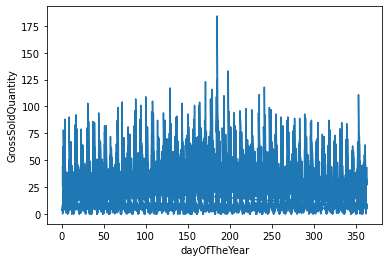

In [13]:
plt.plot(df['dayOfTheYear'], df['GrossSoldQuantity'])
plt.xlabel('dayOfTheYear')
plt.ylabel('GrossSoldQuantity')

Text(0, 0.5, 'GrossSoldQuantity')

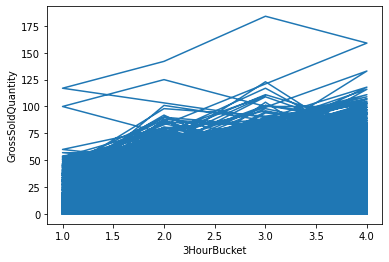

In [14]:
plt.plot(df['3HourBucket'], df['GrossSoldQuantity'])
plt.xlabel('3HourBucket')
plt.ylabel('GrossSoldQuantity')

In [15]:
df.describe()

,StoreNumber,dayOfTheYear,3HourBucket,GrossSoldQuantity
count,5660.000000,5660.000000,5660.000000,5660.000000
mean,2500.706714,181.631449,2.504240,22.690989
std,1118.132545,104.530966,1.115276,22.281150
min,1000.000000,1.000000,1.000000,0.000000
25%,2000.000000,91.000000,2.000000,5.000000
50%,2500.000000,181.000000,3.000000,13.000000
75%,4000.000000,272.000000,3.000000,36.000000
max,4000.000000,363.000000,4.000000,184.000000


In [16]:
#df['Cash_Credit'].unique() # False
#df['EBT'].unique() # True, False
#df['Loyalty'].unique() # True
#df['ExtraMile'].unique() # True
#df['CoBrand'].unique() # No
#df['Alcohol'].unique() # True, False
#df['Carwash'].unique() # False, True
#df['Food_Service'].unique() # True
#df['City'].unique() # Houston, Austin, College Station, San Antonio

# Because there are only ONE unique values for Cash_Credit, Loyalty, ExtraMile, CoBrand, Food_Service, State we can drop them
df = df.drop(['Cash_Credit', 'Loyalty', 'ExtraMile', 'CoBrand', 'Food_Service','State'], axis = 1)
df.head()

,StoreNumber,dayOfTheYear,3HourBucket,GrossSoldQuantity,EBT,Alcohol,Carwash,City
0,1000,1,1,3,TRUE,TRUE,FALSE,HOUSTON
1,1000,1,2,5,TRUE,TRUE,FALSE,HOUSTON
2,1000,1,3,6,TRUE,TRUE,FALSE,HOUSTON
3,1000,1,4,3,TRUE,TRUE,FALSE,HOUSTON
4,1000,2,1,13,TRUE,TRUE,FALSE,HOUSTON


In [17]:
df.corr()

,StoreNumber,dayOfTheYear,3HourBucket,GrossSoldQuantity
StoreNumber,1.000000,-0.000846,-0.000994,0.419910
dayOfTheYear,-0.000846,1.000000,0.001904,-0.009997
3HourBucket,-0.000994,0.001904,1.000000,0.239332
GrossSoldQuantity,0.419910,-0.009997,0.239332,1.000000


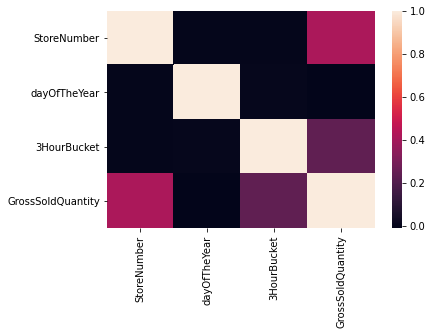

In [18]:
correlation = df.corr()
sns.heatmap(correlation, 
        xticklabels=correlation.columns,
        yticklabels=correlation.columns)

In [19]:
df['StoreNumber'] = df['StoreNumber']/1000
df.head()

,StoreNumber,dayOfTheYear,3HourBucket,GrossSoldQuantity,EBT,Alcohol,Carwash,City
0,1.0,1,1,3,TRUE,TRUE,FALSE,HOUSTON
1,1.0,1,2,5,TRUE,TRUE,FALSE,HOUSTON
2,1.0,1,3,6,TRUE,TRUE,FALSE,HOUSTON
3,1.0,1,4,3,TRUE,TRUE,FALSE,HOUSTON
4,1.0,2,1,13,TRUE,TRUE,FALSE,HOUSTON


In [20]:
train_val, test = train_test_split(df, test_size = 0.175, random_state = 57)
train, val = train_test_split(train_val, test_size = 0.225, random_state = 86)

In [21]:
train.head()

,StoreNumber,dayOfTheYear,3HourBucket,GrossSoldQuantity,EBT,Alcohol,Carwash,City
1865,2.0,116,2,10,FALSE,FALSE,FALSE,AUSTIN
390,1.0,101,4,30,TRUE,TRUE,FALSE,HOUSTON
4764,4.0,134,1,12,FALSE,FALSE,TRUE,SAN ANTONiO
3762,3.0,238,3,5,TRUE,TRUE,TRUE,COLLEGE STATION
4084,3.0,323,2,4,TRUE,TRUE,TRUE,COLLEGE STATION


In [22]:
print('train:', train.shape)
print('validation:', val.shape)
print('test:', test.shape)

train: (3618, 8)
validation: (1051, 8)
test: (991, 8)


In [23]:
Bucketize = ['StoreNumber', '3HourBucket','dayOfTheYear']
CATEGORICAL_COLUMNS = ['City']
Store_Cross = ['EBT', 'Alcohol', 'Carwash']

In [24]:
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  categorical_column = tf.feature_column.categorical_column_with_vocabulary_list(feature_name, train[feature_name].unique())
  indicator_column = tf.feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

for item in Bucketize: # Essentially Categorizing Numerical Data
  bucket = tf.feature_column.numeric_column(item, dtype=tf.float32)
  boundary = list(np.arange(int(df[item].min()) + 1, int(df[item].max()+1)))
  item_buckets = tf.feature_column.bucketized_column(bucket, boundary)
  feature_columns.append(item_buckets)


  # ################## Cross the Day and the Hours together ############################################
  # day = tf.feature_column.numeric_column('dayOfTheYear', dtype=tf.float32)
  # day_boudaries = list(np.arange(int(min(train['dayOfTheYear'])), int(max(train['dayOfTheYear'])), 4))
  # day_bucket = tf.feature_column.bucketized_column(day, day_boudaries)

  # hour = tf.feature_column.numeric_column('3HourBucket', dtype=tf.float32)
  # hr_boundaries = list(np.arange(int(min(train['3HourBucket'])), int(max(train['3HourBucket'])), 4))
  # hr_bucket = tf.feature_column.bucketized_column(hour, hr_boundaries)

  # day_x_hr = tf.feature_column.crossed_column([day_bucket, hr_bucket], hash_bucket_size=100)
  # day_hr_crossed = tf.feature_column.indicator_column(day_x_hr)
  # feature_columns.append(day_hr_crossed)

  ################# Cross all the sites/stores together ################################################
ebt_site = tf.feature_column.categorical_column_with_vocabulary_list('EBT', train['EBT'].unique())
alcohol_store = tf.feature_column.categorical_column_with_vocabulary_list('Alcohol', train['Alcohol'].unique())
carwash_store = tf.feature_column.categorical_column_with_vocabulary_list('Carwash', train['Carwash'].unique())
crosses = tf.feature_column.crossed_column([ebt_site, alcohol_store, carwash_store], hash_bucket_size=100)
stores_crossed = tf.feature_column.indicator_column(crosses)
feature_columns.append(stores_crossed)

model_feature_layers = layers.DenseFeatures(feature_columns)
model_feature_layers

In [25]:
def make_input_fn(data_df, shuffle=True, batch_size=32):
  df = data_df.copy()
  labels = df.pop('GrossSoldQuantity') # Y labels
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))  # create tf.data.Dataset object with data and its label
  if shuffle:
    ds = ds.shuffle(buffer_size=len(data_df))  # randomize order of data
  ds = ds.batch(batch_size) # split dataset into batches of 32
  return ds 

In [26]:
batch_size = 32
train_input_func = make_input_fn(train, shuffle=True, batch_size=batch_size)
val_input_func = make_input_fn(val, shuffle=False, batch_size=batch_size)
test_input_func = make_input_fn(test, shuffle=False, batch_size=batch_size)

In [27]:
def create_model():
  model = None

  model = tf.keras.models.Sequential()

  model.add(model_feature_layers)

  model.add(tf.keras.layers.Dense(units=16, 
                                  activation='relu'))
  
  model.add(tf.keras.layers.Dense(units=8, 
                                  activation='relu'))
  
  model.add(tf.keras.layers.Dense(units=4, 
                                  activation='relu'))

  model.add(tf.keras.layers.Dense(units=1,
                                  activation='linear'))                          
  
  model.compile(loss='mse', optimizer='adam', metrics=[tf.keras.metrics.MeanSquaredError(), 'accuracy', tf.keras.metrics.RootMeanSquaredError()])

  return model

In [28]:
def train_model(model, input_func, val, epochs,
                batch_size=None):

  history = model.fit(x=input_func, validation_data=val, batch_size=batch_size,
                      epochs=epochs, shuffle=True) 
  return history

In [29]:
def plot_the_loss_curve(epochs, error_func):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Error Metric")

  plt.plot(epochs, error_func, label="Loss")
  plt.legend()
  plt.ylim([error_func.min()*0.95, error_func.max() * 1.03])
  plt.show() 

In [30]:
epochs = 100
batch_size = 32
model = create_model()
history1 = train_model(model=model, input_func=train_input_func, val=val_input_func, epochs=epochs, batch_size=batch_size)

Epoch 1/100
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
105/114 [==========================>...] - ETA: 0s - loss: 1000.3827 - mean_squared_error: 1000.3827 - accuracy: 0.0275 - root_mean_squared_error: 31.6206WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'StoreNumber': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=float64>, 'dayOfTheYear': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=int64>, '3HourBucket': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'EBT': <tf.Tensor 'ExpandDims_4:0' shape=(None, 1) dtype=string>, 'Alcohol': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'Carwash': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 'City': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>}
Consider rewriting this model with the Functional API.
114/114 [==============================] - 2s 7m

In [31]:
h = pd.DataFrame(history1.history)
h.tail() # Last Training Samples

,loss,mean_squared_error,accuracy,root_mean_squared_error,val_loss,val_mean_squared_error,val_accuracy,val_root_mean_squared_error
95,58.806217,58.806217,0.030680,7.668521,139.157532,139.157532,0.027593,11.796505
96,58.399410,58.399410,0.030404,7.641951,140.997070,140.997070,0.027593,11.874219
97,58.959557,58.959557,0.030127,7.678513,141.931656,141.931656,0.026641,11.913507
98,58.373760,58.373760,0.031233,7.640272,139.977936,139.977936,0.027593,11.831227
99,58.541164,58.541164,0.029298,7.651220,139.429977,139.429977,0.027593,11.808047


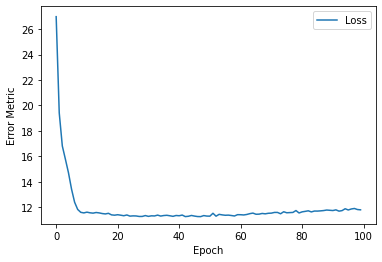

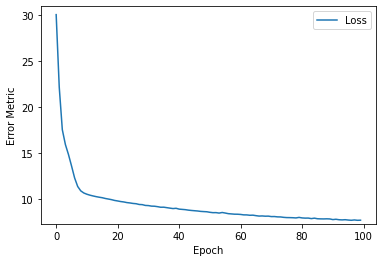

In [32]:
plot_the_loss_curve(history1.epoch, h.val_root_mean_squared_error)
plot_the_loss_curve(history1.epoch, h.root_mean_squared_error)

In [33]:
results = model.evaluate(test_input_func)

31/31 [==============================] - 0s 2ms/step - loss: 129.2280 - mean_squared_error: 129.2280 - accuracy: 0.0434 - root_mean_squared_error: 11.3679


In [34]:
prediction = model.predict(test_input_func)

Consider rewriting this model with the Functional API.


In [35]:
prediction_values = prediction.astype(int)
prediction_values

array([[ 44],
       [ 39],
       [ 46],
       [  4],
       [ 45],
       [  1],
       [ 39],
       [  2],
       [ 35],
       [  3],
       [  7],
       [  4],
       [  8],
       [ 14],
       [ 50],
       [ 34],
       [ 32],
       [  0],
       [ 39],
       [  6],
       [ 67],
       [ 32],
       [ 18],
       [ 55],
       [ 16],
       [ 41],
       [ 68],
       [ 21],
       [ 35],
       [  0],
       [ 45],
       [  7],
       [ 25],
       [ 22],
       [ 34],
       [ 22],
       [ 22],
       [  1],
       [ 48],
       [ 61],
       [ 25],
       [ 16],
       [ 37],
       [  4],
       [ 24],
       [  2],
       [ 33],
       [  4],
       [ 28],
       [ 42],
       [ 24],
       [ 20],
       [ 31],
       [  1],
       [  5],
       [  8],
       [ 93],
       [  7],
       [ 39],
       [ 14],
       [  7],
       [ 17],
       [  4],
       [  4],
       [  3],
       [  6],
       [  5],
       [ 42],
       [ 23],
       [ 30],
       [  4],
      

In [36]:
test.head()

,StoreNumber,dayOfTheYear,3HourBucket,GrossSoldQuantity,EBT,Alcohol,Carwash,City
1563,2.0,39,3,32,FALSE,FALSE,FALSE,AUSTIN
1699,2.0,74,2,27,FALSE,FALSE,FALSE,AUSTIN
5261,4.0,261,2,51,FALSE,FALSE,TRUE,SAN ANTONiO
82,1.0,22,3,3,TRUE,TRUE,FALSE,HOUSTON
4060,3.0,317,2,41,TRUE,TRUE,TRUE,COLLEGE STATION


In [38]:
true_values = test['GrossSoldQuantity'].to_numpy()
true_values = np.reshape(true_values,(991,1))
true_values

array([[ 32],
       [ 27],
       [ 51],
       [  3],
       [ 41],
       [  0],
       [ 50],
       [  0],
       [ 65],
       [  6],
       [  4],
       [  5],
       [  5],
       [  6],
       [ 57],
       [ 55],
       [ 44],
       [  3],
       [ 25],
       [  9],
       [ 82],
       [ 28],
       [ 36],
       [ 67],
       [ 16],
       [ 45],
       [ 39],
       [ 17],
       [ 27],
       [  4],
       [ 24],
       [  6],
       [ 42],
       [ 36],
       [ 37],
       [ 39],
       [ 21],
       [  6],
       [ 51],
       [ 54],
       [ 22],
       [ 15],
       [ 51],
       [  3],
       [ 31],
       [  6],
       [ 35],
       [ 11],
       [ 39],
       [ 37],
       [ 26],
       [ 32],
       [ 40],
       [  4],
       [  7],
       [  6],
       [ 87],
       [  1],
       [ 33],
       [ 13],
       [ 10],
       [ 26],
       [  5],
       [  6],
       [  2],
       [  3],
       [ 10],
       [ 51],
       [ 26],
       [ 22],
       [  5],
      

In [39]:
comparison = np.concatenate((true_values, prediction_values), axis=1)
compare_result = pd.DataFrame(comparison)
compare_result.columns = ['Actual', 'Prediction']
compare_result

,Actual,Prediction
0,32,44
1,27,39
2,51,46
3,3,4
4,41,45
...,...,...
986,8,0
987,74,32
988,51,21
989,3,2


In [40]:
# Determine RMSE for Testing DataSet
def rmse(a,b):
    total = 0
    for i in range(len(a)):
        total += (a[i]-b[i])**2
    total = total/len(a)
    total = math.sqrt(total)
    return total

rmse(true_values, prediction)

11.367849178476959

# Predictions

In [41]:
scoring_df = pd.read_csv("/content/scoring.csv", dtype={'Cash/Credit Site': str, 'EBT Site': str, 'Loyalty Site': str, 'ExtraMile Site': str, 'Alcohol': str, 'Carwash': str, 'Food Service': str}) # Needed to make feature crosses easier
scoring_df = scoring_df.rename(columns={"Cash/Credit Site": "Cash_Credit", "EBT Site": "EBT", "Loyalty Site": "Loyalty", "ExtraMile Site": "ExtraMile", "Food Service": "Food_Service"}) # Needed to have valid scope names
scoring_df = scoring_df.drop(['Cash_Credit', 'Loyalty', 'ExtraMile', 'CoBrand', 'Food_Service','State'], axis = 1) # B/c of decision above
scoring_df['StoreNumber'] = scoring_df['StoreNumber']/1000
scoring_df.head()

,StoreNumber,dayOfTheYear,3HourBucket,GrossSoldQuantity,EBT,Alcohol,Carwash,City
0,1.0,364,1,0,TRUE,TRUE,FALSE,HOUSTON
1,1.0,364,2,3,TRUE,TRUE,FALSE,HOUSTON
2,1.0,364,3,4,TRUE,TRUE,FALSE,HOUSTON
3,1.0,364,4,1,TRUE,TRUE,FALSE,HOUSTON
4,1.0,365,1,9,TRUE,TRUE,FALSE,HOUSTON


In [42]:
test_input_func_2 = make_input_fn(scoring_df, shuffle=False, batch_size=32)

In [43]:
evaluation_results = model.evaluate(test_input_func_2)

1/1 [==============================] - 0s 21ms/step - loss: 45.9597 - mean_squared_error: 45.9597 - accuracy: 0.2500 - root_mean_squared_error: 6.7794


In [44]:
final_prediction = model.predict(test_input_func_2)
final_prediction_values = final_prediction.astype(int)
final_prediction_values

array([[ 5],
       [ 6],
       [ 6],
       [ 6],
       [ 5],
       [ 6],
       [ 6],
       [ 6],
       [ 4],
       [ 6],
       [ 6],
       [ 6],
       [ 4],
       [ 6],
       [ 6],
       [ 6],
       [ 8],
       [ 8],
       [ 7],
       [ 8],
       [ 8],
       [ 8],
       [ 7],
       [ 8],
       [18],
       [24],
       [31],
       [40],
       [18],
       [24],
       [31],
       [40]])

In [47]:
true_values = scoring_df['GrossSoldQuantity'].to_numpy()
true_values = np.reshape(true_values,(32,1)) ################# Find length

In [48]:
comparison = np.concatenate((true_values, final_prediction_values), axis=1)
compare_result = pd.DataFrame(comparison)
compare_result.columns = ['Actual', 'Prediction']
compare_result

,Actual,Prediction
0,0,5
1,3,6
2,4,6
3,1,6
4,9,5
5,9,6
6,3,6
7,6,6
8,1,4
9,2,6


In [49]:
rmse(true_values, final_prediction_values)

6.459005341381906